<a href="https://colab.research.google.com/github/SUMERBASSI/mcqgen/blob/master/COPULAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(0.512281114114467, 'WPRO IS Equity', 'INFO IS Equity')
(0.399711765704378, 'TATA IS Equity', 'JSTL IS Equity')
(0.3727518617178973, 'SBIN IS Equity', 'TATA IS Equity')
(0.35762134210835583, 'ONGC IS Equity', 'INFO IS Equity')
(0.3480663079617452, 'RELIANCE IS Equity', 'TATA IS Equity')


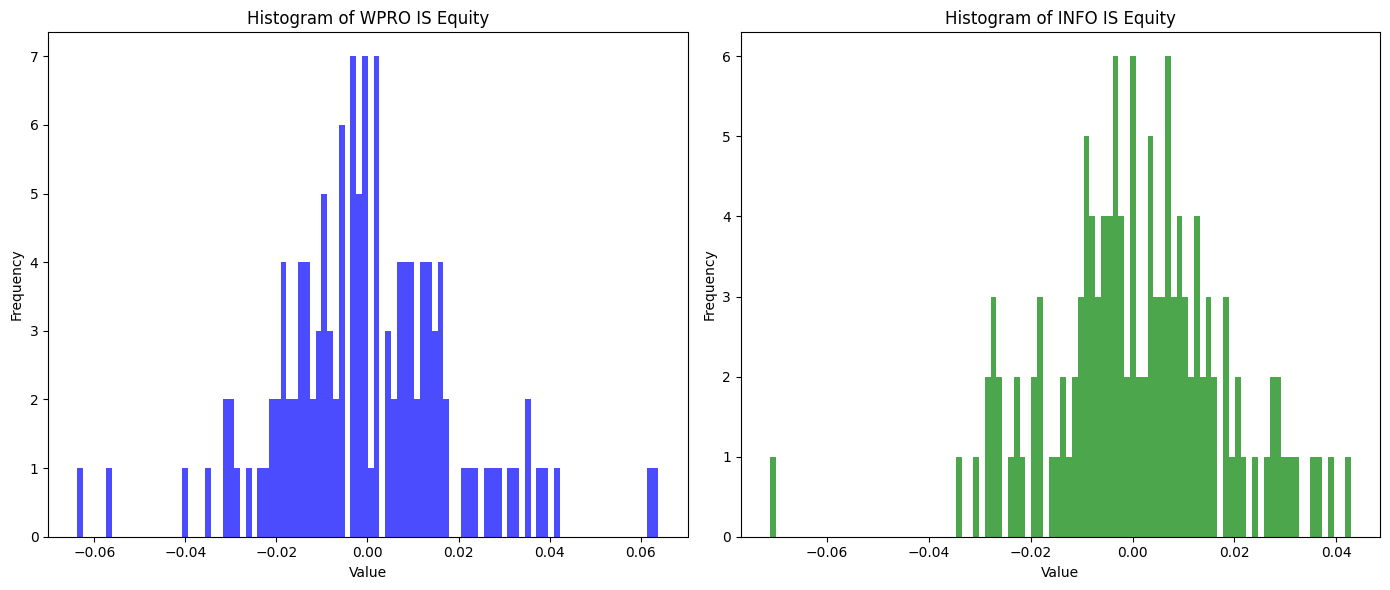

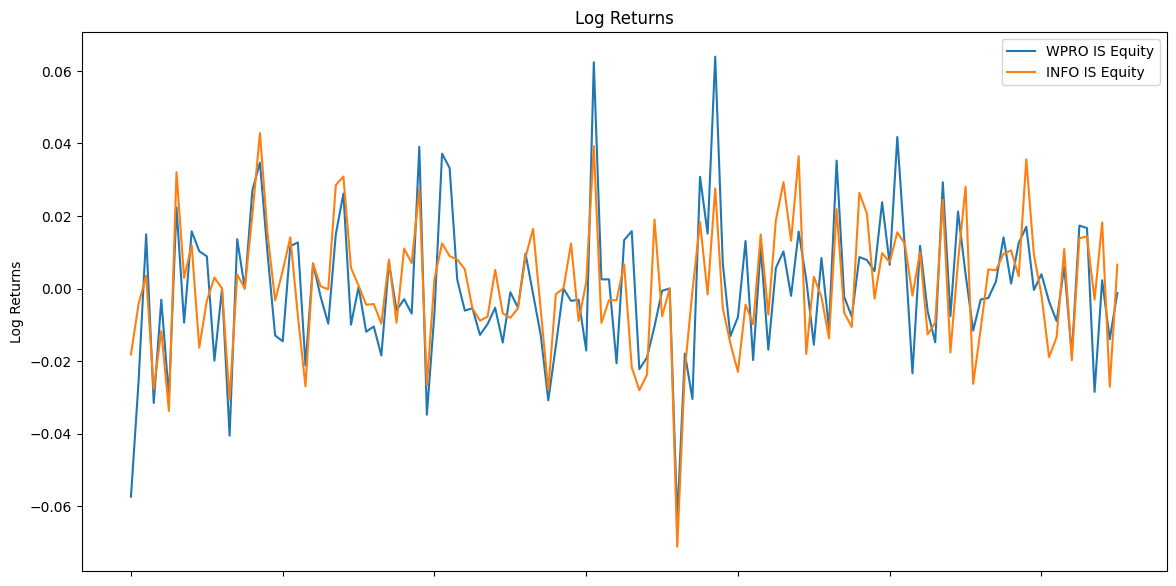

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg,

copulas.univariate.student_t.StudentTUnivariate
---------------
copulas.univariate.student_t.StudentTUnivariate
---------------
Parameters for Clayton: 2.1007228915662646
Log Likelihood for Clayton: 32.81510401026455
AiC for Clayton: -63.630208020529096
----------------------------------
Parameters for Gumbel: 2.0503614457831323
Log Likelihood for Gumbel: 42.496632043062014
AiC for Gumbel: -82.99326408612403
----------------------------------
Parameters for Frank: 5.964059305947411
Log Likelihood for Frank: 43.33970925206603
AiC for Frank: -84.67941850413206
----------------------------------
Copula with the lowest AiC: Frank
(131,)
(131,)
Trade Start
Trade start at index 31 on 2005-08-19 00:00:00
Prices at trade start: {'WPRO IS Equity': 72.25, 'INFO IS Equity': 143.84}
Trade End
Trade end at index 101 on 2005-11-25 00:00:00
Prices at trade end: {'WPRO IS Equity': 88.21, 'INFO IS Equity': 171.28}
Trade Start
Trade start at index 103 on 2005-11-29 00:00:00
Prices at trade start: {'WPRO

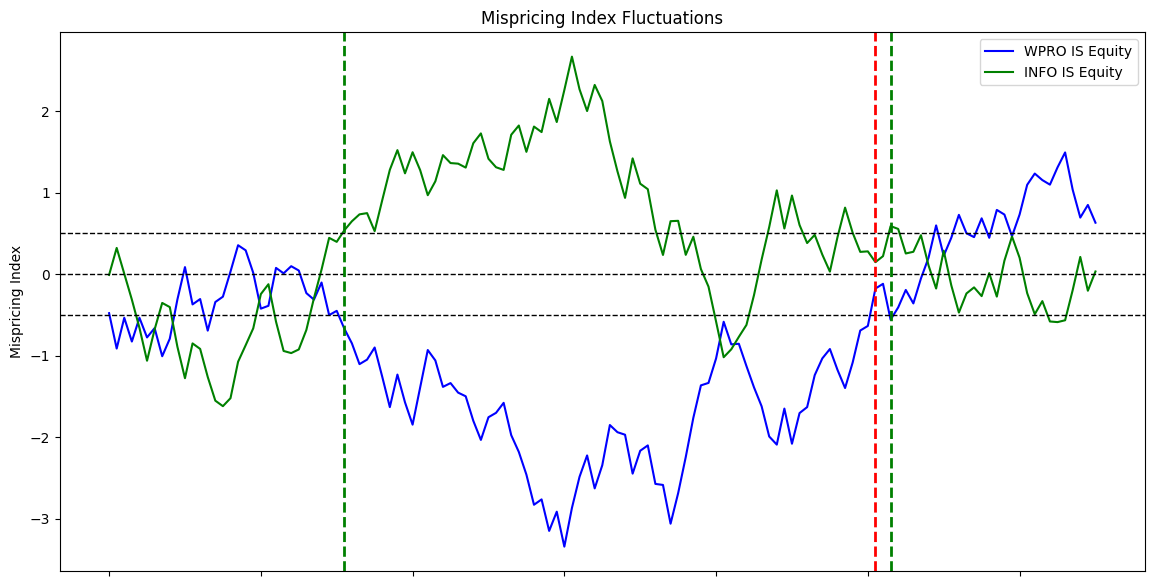

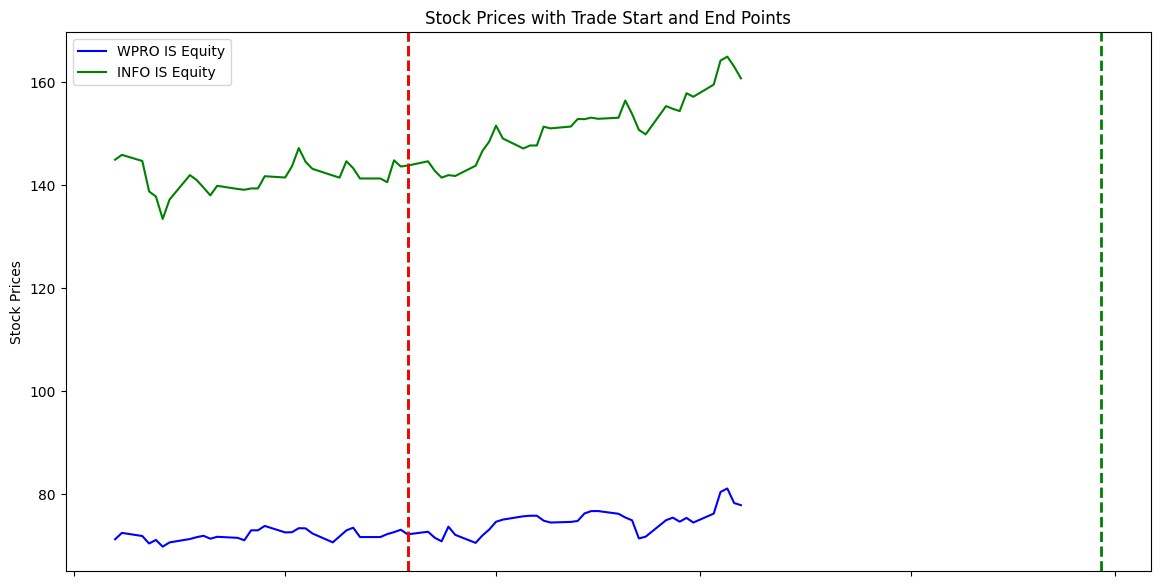

In [ ]:
!pip install copulas
!pip install copulae

import pandas as pd
import scipy.stats
import itertools
import numpy as np
import matplotlib.pyplot as plt
from copulas.univariate import Univariate
from copulae import GaussianCopula, StudentCopula, ClaytonCopula, FrankCopula, GumbelCopula
from scipy.spatial.distance import euclidean
from copulas.bivariate import Frank, Gumbel, Clayton

def convert_to_log_returns(file_path):
    df = pd.read_csv(file_path, index_col=0)
    log_returns = np.log(df / df.shift(1)).dropna()
    return log_returns

def calculate_kendall_tau(df):
    results = []
    for stock1, stock2 in itertools.combinations(df.columns, 2):
        tau, _ = scipy.stats.kendalltau(df[stock1], df[stock2])
        results.append((tau, stock1, stock2))
    results.sort(reverse=True, key=lambda x: x[0])
    return results

def calculate_distance(df):
    results = []
    for stock1, stock2 in itertools.combinations(df.columns, 2):
        distance = euclidean(df[stock1], df[stock2])
        results.append((distance, stock1, stock2))
    results.sort(key=lambda x: x[0])
    return results

def plot_histograms(df, column_name1, column_name2):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df[column_name1], bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram of {column_name1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    plt.hist(df[column_name2], bins=100, color='green', alpha=0.7)
    plt.title(f'Histogram of {column_name2}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_log_returns(df, stock1, stock2, title):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[stock1], label=stock1)
    plt.plot(df.index, df[stock2], label=stock2)
    plt.ylabel('Log Returns')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ''))
    plt.title(title)
    plt.legend()
    plt.show()

def fit_univariate_distributions(df, column_name1, column_name2):
    univariate1 = Univariate()
    univariate1.fit(df[column_name1])
    parameters1 = univariate1.to_dict()
    cdf1 = univariate1.cumulative_distribution

    univariate2 = Univariate()
    univariate2.fit(df[column_name2])
    parameters2 = univariate2.to_dict()
    cdf2 = univariate2.cumulative_distribution

    return cdf1, cdf2, parameters1['type'], parameters2['type']

def calculate_pseudo_observations(df, cdf1, cdf2, column_name1, column_name2):
    pseudo_obs1 = df[column_name1].apply(cdf1)
    pseudo_obs2 = df[column_name2].apply(cdf2)
    data = np.column_stack((pseudo_obs1, pseudo_obs2))
    return np.array(data)

def calculate_aic(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

def fit_copulas(data):
    copulas = {
        'Clayton': Clayton(),
        'Gumbel': Gumbel(),
        'Frank': Frank()
    }
    aic_values = {}

    for name, cop in copulas.items():
        cop.fit(data)
        ll = np.sum(np.log(cop.probability_density(data)))
        aic = calculate_aic(ll, 1)
        aic_values[name] = aic
        print(f'Parameters for {name}:', cop.compute_theta())
        print(f'Log Likelihood for {name}:', ll)
        print(f'AiC for {name}:', aic)
        print('----------------------------------')

    best_copula_name = min(aic_values, key=aic_values.get)
    best_copula = copulas[best_copula_name]
    print('Copula with the lowest AiC:', best_copula_name)

    return best_copula

def calculate_conditional_probabilities(data, best_copula):
    u1, u2 = data[:, 0], data[:, 1]

    if isinstance(best_copula, Clayton):
        conditional_u1_given_u2 = best_copula.partial_derivative(np.column_stack((u1, u2)))
        conditional_u2_given_u1 = best_copula.partial_derivative(np.column_stack((u2, u1)))

    elif isinstance(best_copula, Gumbel):
        conditional_u1_given_u2 = best_copula.partial_derivative(np.column_stack((u1, u2)))
        conditional_u2_given_u1 = best_copula.partial_derivative(np.column_stack((u2, u1)))

    elif isinstance(best_copula, Frank):
        conditional_u1_given_u2 = best_copula.partial_derivative(np.column_stack((u1, u2)))
        conditional_u2_given_u1 = best_copula.partial_derivative(np.column_stack((u2, u1)))

    else:
        raise ValueError('Unsupported copula type.')

    return conditional_u1_given_u2, conditional_u2_given_u1

file_path = 'prices.csv'
Log_returns= convert_to_log_returns(file_path)
Log_returns.to_csv('Log_returns.csv')
file_path = 'Log_returns.csv'
dataset = pd.read_csv(file_path)
df = dataset.iloc[0:131, 1:22]

results = calculate_kendall_tau(df)
for i in range (0,5):
    print(results[i])

column_name1 = 'WPRO IS Equity'
column_name2 = 'INFO IS Equity'
plot_histograms(df, column_name1, column_name2)
Log_returns.index = pd.to_datetime(Log_returns.index, dayfirst=True)
plot_log_returns(df, column_name1, column_name2, 'Log Returns')

cdf1, cdf2, dist1_type, dist2_type = fit_univariate_distributions(df, column_name1, column_name2)
print(dist1_type)
print('---------------')
print(dist2_type)
print('---------------')

data=calculate_pseudo_observations(df, cdf1, cdf2, column_name1, column_name2)

# dc = pd.DataFrame(data)
# _,_,dist1_type,dist2_type = fit_univariate_distributions(dc, 0, 1)
# print(dist1_type)
# print('---------------')
# print(dist2_type)
# print('---------------')

best_cop=fit_copulas(data)

u1, u2 = dataset.iloc[132:199][column_name1], dataset.iloc[132:199][column_name2]
u1 = u1.apply(cdf1)
u2 = u2.apply(cdf2)
u1_given_u2, u2_given_u1 = calculate_conditional_probabilities(data, best_cop)
u1_given_u2=u1_given_u2.flatten()
u2_given_u1=u2_given_u1.flatten()

for i in range (len(u1_given_u2)):
  u1_given_u2[i]-=0.5
  u2_given_u1[i]-=0.5

print(u1_given_u2.shape)
print(u2_given_u1.shape)

M1=[]
M2=[]

sum1=0
sum2=0

for i in range (len(u1_given_u2)):
  sum1+=u1_given_u2[i]
  M1.append(sum1)

for i in range (len(u2_given_u1)):
  sum2+=u2_given_u1[i]
  M2.append(sum2)

# print(M1)
# print(M2)
data = np.column_stack((M1,M2))
dc = pd.DataFrame(data, columns=['M1', 'M2'])

plt.figure(figsize=(14, 7))
plt.plot(dc['M1'], label=column_name1, color='blue')
plt.plot(dc['M2'], label=column_name2, color='green')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ''))
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-0.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Mispricing Index')
plt.title('Mispricing Index Fluctuations')
plt.legend()


trade_started = False
trade_start_idx = None

file_path = 'prices.csv'
prices_df = pd.read_csv(file_path, index_col=0)
prices_df.index = pd.to_datetime(prices_df.index, dayfirst=True)

trade_indices = []

for idx, (u1, u2) in enumerate(zip(M1, M2)):
    if not trade_started:
        if (u1 > 0.5 and u2 < -0.5) or (u1 < -0.5 and u2 > 0.5):
            trade_start_idx = idx
            plt.axvline(x=trade_start_idx, color='green', linestyle='--', linewidth=2)
            trade_started = True
            trade_indices.append((trade_start_idx, 'start'))
            print("Trade Start")
            trade_start_date = prices_df.index[132 + trade_start_idx]
            trade_start_prices = prices_df.loc[trade_start_date, [column_name1, column_name2]]
            print(f"Trade start at index {trade_start_idx} on {trade_start_date}")
            print(f"Prices at trade start: {trade_start_prices.to_dict()}")


    else:
        if abs(u1) < 2e-1 and abs(u2) < 2e-1:
            trade_end_idx = idx
            plt.axvline(x=trade_end_idx, color='red', linestyle='--', linewidth=2)
            trade_started = False
            trade_indices.append((trade_start_idx, 'end'))
            print("Trade End")
            trade_end_date = prices_df.index[132 + trade_end_idx]
            trade_end_prices = prices_df.loc[trade_end_date, [column_name1, column_name2]]
            print(f"Trade end at index {trade_end_idx} on {trade_end_date}")
            print(f"Prices at trade end: {trade_end_prices.to_dict()}")



plt.figure(figsize=(14, 7))
plt.plot(prices_df.index[132:199], prices_df[column_name1].iloc[132:199], label=column_name1, color='blue')
plt.plot(prices_df.index[132:199], prices_df[column_name2].iloc[132:199], label=column_name2, color='green')
for idx, position in trade_indices:
    color = 'green' if position == 'start' else 'red'
    plt.axvline(x=prices_df.index[132 + idx], color=color, linestyle='--', linewidth=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ''))
plt.ylabel('Stock Prices')
plt.title('Stock Prices with Trade Start and End Points')
plt.legend()

plt.show()







